In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [3]:
xx

array([[-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       ...,
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ],
       [-7.        , -6.85858586, -6.71717172, ...,  6.71717172,
         6.85858586,  7.        ]])

In [4]:
yy

array([[-7.        , -7.        , -7.        , ..., -7.        ,
        -7.        , -7.        ],
       [-6.85858586, -6.85858586, -6.85858586, ..., -6.85858586,
        -6.85858586, -6.85858586],
       [-6.71717172, -6.71717172, -6.71717172, ..., -6.71717172,
        -6.71717172, -6.71717172],
       ...,
       [ 6.71717172,  6.71717172,  6.71717172, ...,  6.71717172,
         6.71717172,  6.71717172],
       [ 6.85858586,  6.85858586,  6.85858586, ...,  6.85858586,
         6.85858586,  6.85858586],
       [ 7.        ,  7.        ,  7.        , ...,  7.        ,
         7.        ,  7.        ]])

In [5]:
random_state = np.random.RandomState(42)
# Define nine outlier detection tools to be compared
classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'Locally Selective Combination (LSCP)': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state)
}

1 fitting Angle-based Outlier Detector (ABOD)
2 fitting Cluster-based Local Outlier Factor (CBLOF)
3 fitting Feature Bagging
4 fitting Histogram-base Outlier Detection (HBOS)
5 fitting Isolation Forest
6 fitting K Nearest Neighbors (KNN)
7 fitting Average KNN
8 fitting Local Outlier Factor (LOF)
9 fitting Minimum Covariance Determinant (MCD)
10 fitting One-class SVM (OCSVM)
11 fitting Principal Component Analysis (PCA)
12 fitting Locally Selective Combination (LSCP)


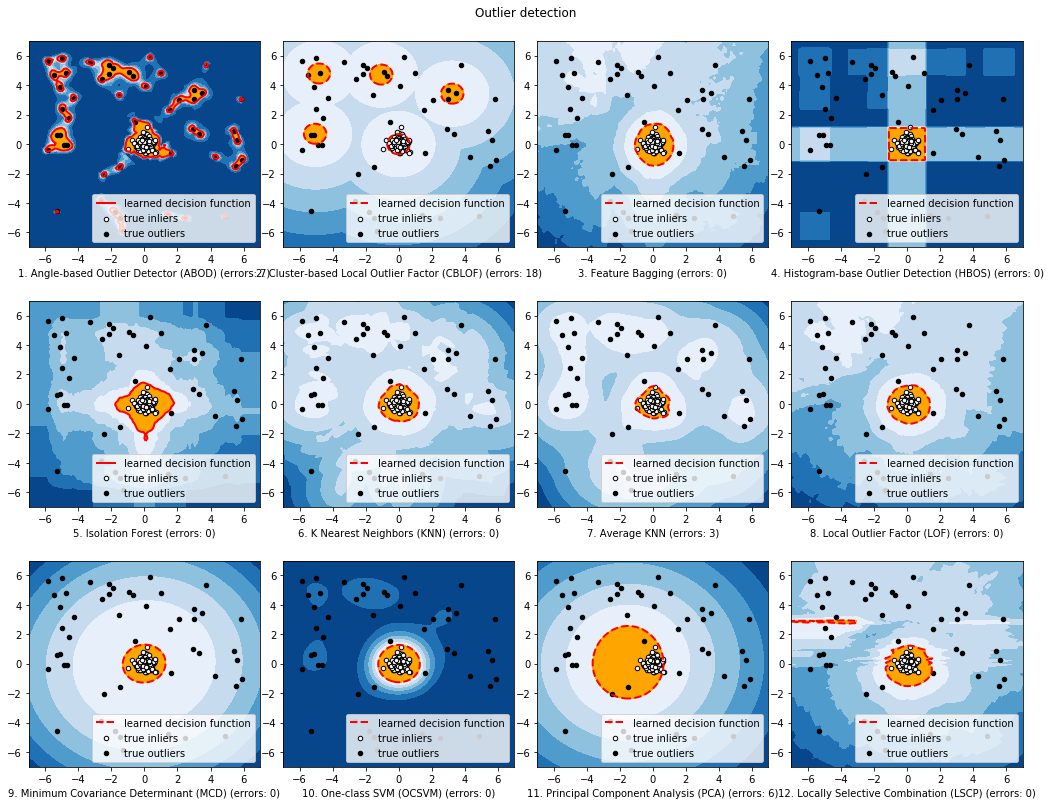

In [7]:
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(15, 12))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        print(i + 1, 'fitting', clf_name)
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 4, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.show()